In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import re

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import torch.distributions as dist

In [ ]:
data = np.loadtxt('/content/drive/MyDrive/approxinf/co2.txt')

In [ ]:
print(data)

[[1.980000e+03 1.000000e+00 1.980042e+03 3.385500e+02 3.379300e+02]
 [1.980000e+03 2.000000e+00 1.980125e+03 3.392700e+02 3.382200e+02]
 [1.980000e+03 3.000000e+00 1.980208e+03 3.396000e+02 3.382500e+02]
 ...
 [2.021000e+03 6.000000e+00 2.021458e+03 4.153500e+02 4.147900e+02]
 [2.021000e+03 7.000000e+00 2.021542e+03 4.136600e+02 4.149400e+02]
 [2.021000e+03 8.000000e+00 2.021625e+03 4.123500e+02 4.150900e+02]]


In [ ]:
t_s, Y_s, trend_Y_s = torch.tensor(data[:,2]), torch.tensor(data[:,3]), torch.tensor(data[:,4])

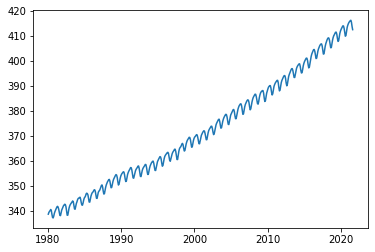

In [ ]:
plt.plot(t_s, Y_s)

In [ ]:
"""
posterior_mean and covariance
"""

mean_ab = torch.tensor([0,360])
precision_ab = torch.diag(torch.tensor([1/100,1/10000]))

N =  t_s.size()[0]

off_diag = t_s.sum()
first_element = (t_s**2).sum()

tt_transpose_matrix = torch.tensor([[first_element, off_diag], [off_diag, N]])

precision_matrix = precision_ab + tt_transpose_matrix
Covariance = torch.linalg.inv(precision_matrix)

T = torch.concat((t_s.unsqueeze(1), torch.ones_like(t_s.unsqueeze(1))), dim = 1)
y_T = torch.diag(Y_s) @ T

mean = Covariance @ (precision_ab @ mean_ab.float() + y_T.sum(dim=0))

In [ ]:
print(precision_matrix)
print(Covariance)
print(mean)

tensor([[2.0017e+09, 1.0004e+06],
        [1.0004e+06, 5.0000e+02]], dtype=torch.float64)
tensor([[ 1.3748e-05, -2.7507e-02],
        [-2.7507e-02,  5.5040e+01]], dtype=torch.float64)
tensor([ 1.8184e+00, -3.2662e+03], dtype=torch.float64)


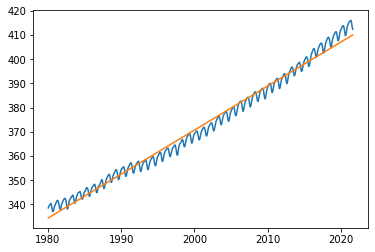

In [ ]:
MAP = mean[0].item()*t_s + mean[1].item()
plt.plot(t_s, Y_s)
plt.plot(t_s, MAP)

"\nConforms to prior belief: \n\nDoesn't conform to prior belief: The overall shape of the curve\n(dips in middle) does not conform to prior belief of a linear model,\nif it did we would expect a curve that has oscillations about some constant value\n\nOscillations, cannot be modelled by random gaussian \nnoise\n"

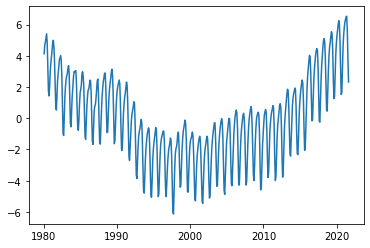

In [ ]:
"""
The residual
"""
predicted = (T @ torch.diag(mean)).sum(dim=1)
residual = Y_s - predicted
plt.plot(t_s,residual)

"""
Conforms to prior belief: 

Doesn't conform to prior belief: The overall shape of the curve
(dips in middle) does not conform to prior belief of a linear model,
if it did we would expect a curve that has oscillations about some constant value

Oscillations, cannot be modelled by random gaussian 
noise
"""

In [ ]:
"""
Function to gnerate samples from a GP, given a covariance kernel k(.,.)
First I consider a general Kernel function, then a translationally
invariant kernel function
"""
#Gaussian process with general Kernel 'k'
def GP(x,k):
  def kernel_matrix(x):
    K = torch.zeros((x.size()[0],x.size()[0]))
    for i in range(x.size()[0]):
      for j in range(x.size()[0]):
        K[i][j] = k(x[i],x[j])
    return K

  dist = dist.multivariate_normal.MultivariateNormal(torch.zeros(x.size()[0]), 
                                                     kernel_matrix(x))
  return dist.sample()

"""I now write a function more appropriate to the next question, 'K' is 
a function that acts on the matrix of distances between each element of x.
this forms the kernel matrix"""
def translation_inv_GP(x, K, theta, tau, sigma, phi, eta, zeta):
  distances = torch.cdist(x.unsqueeze(1),x.unsqueeze(1))
  K_matrix = K(distances, theta, tau, sigma, phi, eta, zeta)
  plt.imshow(K_matrix, interpolation='nearest')
  plt.title(f'theta = {theta}, tau = {tau}, sigma = {sigma}, phi = {phi}, eta = {eta}, zeta={zeta}')
  plt.show()

  gaussian = dist.multivariate_normal.MultivariateNormal(
      torch.zeros(x.size()[0]).double(), K_matrix)
  return gaussian.sample()

In [ ]:
"""
d) Testing the above function, I first define the Kernel function
"""
def K(X, theta, tau, sigma, phi, eta, zeta):
  exp_1 = torch.exp(- 2 * torch.sin(X * np.pi/tau)**2 / (sigma**2))
  exp_2 = torch.exp(- X**2 / (2* eta**2))
  diagonal = zeta*zeta * torch.eye(X.size()[0])
  kernel_matrix = theta**2 * (exp_1 + (phi**2 * exp_2)) + diagonal
  
  return (kernel_matrix + kernel_matrix.t())/2

In [ ]:
print(t_s.size())

torch.Size([500])


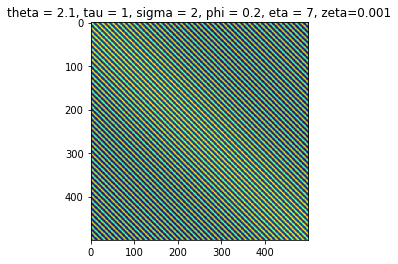

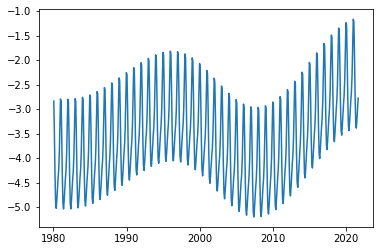

In [ ]:
f = translation_inv_GP(t_s, K, 2, 1, 2, 0.2, 7, 0.001)
plt.plot(t_s,f)

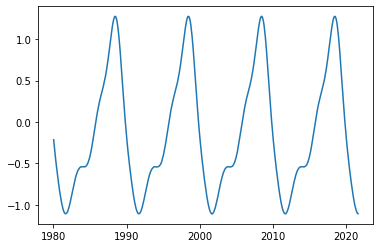

In [ ]:
"""
phi and eta control the decay in the envoloping function of the correlation
between points. With phi = 0, the covariance matrix is perfectly periodic with
distance and gives periodic functions, increasing phi gradually destroys the 
long range correlations, 

decreasing the long range periodic correlations gives a function that 
"""

In [ ]:
"""
theta controls the overall scale of the function
Tau control the smoothness, smaller tau gives greater frequency of oscillation
Sigma controls the magnitude of the high frequency oscillations, smaller sigma 
gives larger magnitude. NOT TRUE
"""

'\nTau control the smoothness, smaller tau gives greater frequency of oscillation\n'

In [ ]:
print(t_s)

tensor([1980.0420, 1980.1250, 1980.2080, 1980.2920, 1980.3750, 1980.4580,
        1980.5420, 1980.6250, 1980.7080, 1980.7920, 1980.8750, 1980.9580,
        1981.0420, 1981.1250, 1981.2080, 1981.2920, 1981.3750, 1981.4580,
        1981.5420, 1981.6250, 1981.7080, 1981.7920, 1981.8750, 1981.9580,
        1982.0420, 1982.1250, 1982.2080, 1982.2920, 1982.3750, 1982.4580,
        1982.5420, 1982.6250, 1982.7080, 1982.7920, 1982.8750, 1982.9580,
        1983.0420, 1983.1250, 1983.2080, 1983.2920, 1983.3750, 1983.4580,
        1983.5420, 1983.6250, 1983.7080, 1983.7920, 1983.8750, 1983.9580,
        1984.0420, 1984.1250, 1984.2080, 1984.2920, 1984.3750, 1984.4580,
        1984.5420, 1984.6250, 1984.7080, 1984.7920, 1984.8750, 1984.9580,
        1985.0420, 1985.1250, 1985.2080, 1985.2920, 1985.3750, 1985.4580,
        1985.5420, 1985.6250, 1985.7080, 1985.7920, 1985.8750, 1985.9580,
        1986.0420, 1986.1250, 1986.2080, 1986.2920, 1986.3750, 1986.4580,
        1986.5420, 1986.6250, 1986.708

In [ ]:
t_prime = torch.linspace(2021.958, 2034.906, 156).double()


In [ ]:
def K_2(X, theta, tau, sigma, phi, eta, zeta):
  exp_1 = torch.exp(- 2 * torch.sin(X * np.pi/tau)**2 / (sigma**2))
  exp_2 = torch.exp(- X**2 / (2* eta**2))
  kernel_matrix = theta**2 * (exp_1 + (phi**2 * exp_2))
  
  return kernel_matrix

In [ ]:
def Kernel_mat(x, t, K, theta, tau, sigma, phi, eta, zeta):
  distances = torch.cdist(x.unsqueeze(1),t.unsqueeze(1))
  K_matrix = K(distances, theta, tau, sigma, phi, eta, zeta)
  
  return K_matrix
  

In [ ]:
K_prime = Kernel_mat(t_s, t_prime, K_2, 2, 1, 2, 0.2, 1, 0.01)

In [ ]:
K_tilde = Kernel_mat(t_s, t_s, K, 2, 1, 2, 0.2, 1, 0.01)

In [ ]:
print(K_tilde.size())
print(residual.size())

torch.Size([500, 500])
torch.Size([500])


In [ ]:
g_prime_means = K_prime.t() @ K_tilde.inverse() @ residual

In [ ]:
g_prime_std = torch.sqrt(torch.diagonal(K_prime.t() @ K_tilde.inverse() @ K_prime))

In [ ]:
T_s = torch.concat((t_s, t_prime),0)
g_extrap = mean[0].item()*t_prime + mean[1].item() + g_prime_means
Y_new = residual + MAP

Text(0.5, 1.0, 'theta = 2.1, tau=1, sigma=2, phi=0.2, eta=1, zeta=0.01')

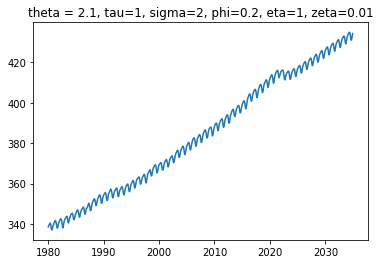

In [ ]:
plt.plot(T_s, torch.concat((Y_new,g_extrap),0))
plt.title('theta = 2.1, tau=1, sigma=2, phi=0.2, eta=1, zeta=0.01')

Text(0.5, 1.0, 'theta = 2.1, tau=1, sigma=2, phi=0.2, eta=1, zeta=0.01')

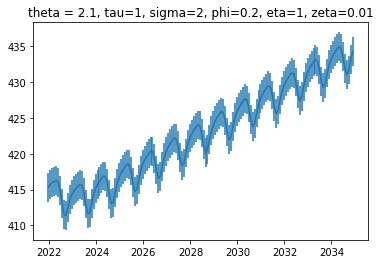

In [ ]:
plt.errorbar(t_prime, g_extrap, yerr= g_prime_std)
plt.title('theta = 2.1, tau=1, sigma=2, phi=0.2, eta=1, zeta=0.01')